In [1]:
# pip install scikit-learn

In [2]:
# pip install matplotlib

In [3]:
# pip install openpyxl

In [4]:
import requests
import json
import pandas as pd
import time
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [21]:
import joblib

In [5]:
'''
    The address used for training the ML model
'''

addresses = ['2993tWVVBGnzkWzLWTSLHByX9FAaNH7j1QoQBnDgxH71','arsc4jbDnzaqcCLByyGo7fg7S2SmcFsWUzQuDtLZh2y','9J41nRFg5aega9WAcrSxR9NBJRneQ5sWptyv1cAcFG5j', 'FeQ6UuJXJoeVkBi6p7eNMxH2E962TktzSMo9kpuQnsgG', 'Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96' , 'HPnPbn8ryBpPhW9ddMo8BdDLm3ec6j9fes1JWCyhVtZA', 'HWEoBxYs7ssKuudEjzjmpfJVX7Dvi7wescFsVx2L5yoY',
            'MJKqp326RZCHnAAbew9MDdui3iCKWco7fsK9sVuZTX2', '52C9T2T7JRojtxumYnYZhyUmrN7kqzvCLc4Ksvjk7TxD', '8BseXT9EtoEhBTKFFYkwTnjKSUZwhtmdKY2Jrj8j45Rt',
            'GitYucwpNcg6Dx1Y15UQ9TQn8LZMX1uuqQNn8rXxEWNC', '9QgXqrgdbVU8KcpfskqJpAXKzbaYQJecgMAruSWoXDkM','58qEoZWDhRXJLZM81dhGBE9yX8SurkZXwcshRUt2eiwy',
            'Ab6SDGKe5VLnYBuq4sEgbZ3t58QT6okhmAFn37VhKEBe','G2Lv2uKycrMCXEZ2KCmX7SZiDfK9ua2HTQGLdFvqTdQS','5yhAyfR5Z7ALwkU7vSH2AjnvLqJb7Zu5DPCEVocvkSwC',
            '2BN5nmMtQFmwyW9EGiQEintCiU5eNtPS9Us4m46LXzGQ']

In [6]:
accountTxDatas = []

In [7]:
'''
    Fetch their onchain data
'''

for i in addresses:
    time.sleep(1)
    
    url = f"https://api.solana.fm/v0/accounts/{i}/transfers"
    response = requests.get(url)

    parssedTxResult = []
    if response.status_code == 200:
        data = response.json()
        
        results = data.get('results')
        
        for tx in results:
            data = tx.get('data',[])
    
            for i in data:
                # if (i.get('action')).startswith('mintToCollection') :
                    parssedTxResult.append(
                        {
                            'status' : i.get('status'),
                            'action' : i.get('action'),
                            'Amount' : i.get('amount'),
                            'Receiver' : i.get('destination'),
                            'TimeStamp' : i.get('timestamp'),
                        }
                    )
        accountTxDatas.append(parssedTxResult)
        df = pd.DataFrame(list)
        df.to_excel('minted.xlsx', index=False)
        
    else:
        print(f"Request failed with status code {response.status_code}")

In [8]:
all_transactions = []

'''
    Extract the required data from the onchian result
'''

for address, transactions in zip(addresses, accountTxDatas):
    for tx in transactions:

        transaction_record = {
            'address': address,
            'timestamp': tx['TimeStamp'],
            'action': tx['action'],
            'amount': tx['Amount'],
            'counterparty': tx['Receiver'],
            'status': tx['status']
        }
        all_transactions.append(transaction_record)


In [9]:
df = pd.DataFrame(all_transactions)
df.to_excel('all-transactions.xlsx', index=False)

In [10]:
df = pd.read_excel('all-transactions.xlsx')

data = {'address': [], 'transactions': []}

grouped = df.groupby('address')
for address, group in grouped:
    data['address'].append(address)
    
    transactions = []
    for _, row in group.iterrows():
        transaction = {
            'timestamp': datetime.fromtimestamp(row['timestamp']),
            'action': row['action'],
            'amount': row['amount'],
            'counterparty': row['counterparty'],
            'status': row['status']
        }
        transactions.append(transaction)
    
    data['transactions'].append(transactions)


In [11]:

def calculate_total_transactions(transactions):
    return len(transactions)

def calculate_daily_transaction_count(transactions):
    daily_count = {}
    
    for tx in transactions:
        date = tx['timestamp'].strftime('%Y-%m-%d')
        if date not in daily_count:
            daily_count[date] = 1
        daily_count[date] += 1
    return daily_count

def calculate_transaction_intervals(transactions):
    intervals = []
    timestamps = [tx['timestamp'] for tx in transactions]
    timestamps.sort()
    for i in range(1, len(timestamps)):
        interval = (timestamps[i] - timestamps[i-1]).total_seconds() / 3600.0
        intervals.append(interval)
    return intervals

def calculate_total_transaction_volume(transactions):
    return sum(tx['amount'] for tx in transactions)

def calculate_mean_transaction_amount(transactions):
    return np.mean([tx['amount'] for tx in transactions])

def calculate_variance_transaction_amount(transactions):
    return np.var([tx['amount'] for tx in transactions])

def calculate_unique_counterparties(transactions):
    counterparties = set(tx['counterparty'] for tx in transactions)
    return len(counterparties)

def detect_high_frequency_bursts(transactions, threshold=1):
    bursts = 0
    intervals = calculate_transaction_intervals(transactions)
    for interval in intervals:
        if interval < threshold:
            bursts += 1
    return bursts

In [12]:
def calculate_success_rate(transactions):
    total_transactions = len(transactions)
    successful_transactions = sum(1 for tx in transactions if tx['status']== 'Successful')
    return successful_transactions / total_transactions if total_transactions > 0 else 0

def calculate_time_of_day_activity(transactions):
    hours = [tx['timestamp'].hour for tx in transactions]
    return np.mean(hours) if hours else 0

def calculate_transfer_counts(transactions):
    transfer_counts = [
        "transfer",
        "transferWithSeed",
        "transferChecked",
        "transferCheckedWithFee"
    ]

    transfer = 0
    for tx in transactions:
        tx_type = tx['action']
        if tx_type in transfer_counts:
            transfer += 1
    
    return transfer/len(transactions)

def calculate_mint_and_sig_counts(transactions):
    account_creation_counts = [
        "mintTo",
        "initializeMint",
        "initializeMint2",
        "initializeMultisig",
        "initializeMultisig2"
    ]

    count = 0
    for tx in transactions:
        tx_type = tx['action']
        if tx_type in account_creation_counts:
            count += 1
    
    return count/len(transactions)

In [13]:
'''
    Feature extraction from the extracted data, which will be used to train the model
'''

features = []
for transactions in data['transactions']:
    total_transactions = calculate_total_transactions(transactions)
    daily_transaction_count = calculate_daily_transaction_count(transactions)
    transaction_intervals = calculate_transaction_intervals(transactions)
    total_transaction_volume = calculate_total_transaction_volume(transactions)
    mean_transaction_amount = calculate_mean_transaction_amount(transactions)
    variance_transaction_amount = calculate_variance_transaction_amount(transactions)
    unique_counterparties = calculate_unique_counterparties(transactions)
    high_frequency_bursts = detect_high_frequency_bursts(transactions)
    success_rate = calculate_success_rate(transactions)
    time_of_day_activity = calculate_time_of_day_activity(transactions)

    transfer_counts = calculate_transfer_counts(transactions)
    mint_and_sig_counts = calculate_mint_and_sig_counts(transactions)
    
    feature_vector = [
        total_transactions,
        len(daily_transaction_count),  
        np.mean(transaction_intervals) if transaction_intervals else 0,
        total_transaction_volume,
        mean_transaction_amount,
        variance_transaction_amount,
        unique_counterparties,
        high_frequency_bursts,
        success_rate,
        time_of_day_activity,
        transfer_counts,
        mint_and_sig_counts
    ]
    
    features.append(feature_vector)

In [14]:

feature_names = [
    'Total_Transactions',
    'Unique_Days',
    'Mean_Transaction_Interval',
    'Total_Transaction_Volume',
    'Mean_Transaction_Amount',
    'Variance_Transaction_Amount',
    'Unique_Counterparties',
    'High_Frequency_Bursts',
    'Success_Rate',
    'Time_Of_Activity',
    'Transfer_Counts',
    'Mint_And_Sig_Counts'
]


In [15]:
features_df = pd.DataFrame(features, columns=feature_names)

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

In [17]:
'''
    Training the model
'''

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_features)
labels = kmeans.labels_

In [18]:
# Add cluster labels
features_df['Cluster'] = labels

In [19]:
# model result and analysis
print(features_df)

    Total_Transactions  Unique_Days  Mean_Transaction_Interval  \
0                  278            2                   0.117475   
1                   11            1                   0.000000   
2                   72            1                   0.048259   
3                   11            1                   0.000000   
4                  918            1                   0.011382   
5                   11            1                   0.000000   
6                  119            3                   0.504461   
7                  404            1                   0.046330   
8                   13            2                   2.313912   
9                  116            3                   0.427116   
10                 199            1                   0.000004   
11                 128            3                   0.503869   
12                  20            3                   3.361579   
13                 352            1                   0.000066   

    Total

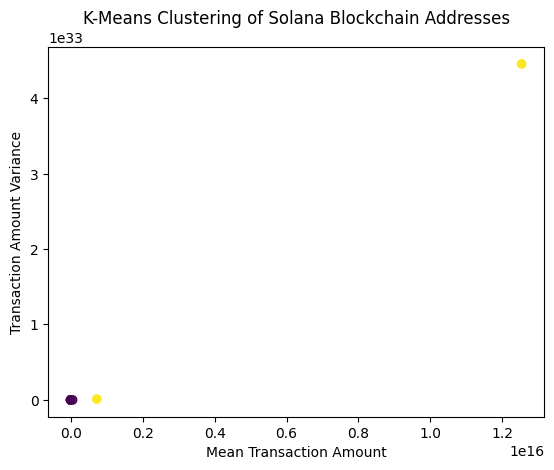

In [20]:
plt.scatter(features_df['Mean_Transaction_Amount'], features_df['Variance_Transaction_Amount'], c=features_df['Cluster'], cmap='viridis')
plt.xlabel('Mean Transaction Amount')
plt.ylabel('Transaction Amount Variance')
plt.title('K-Means Clustering of Solana Blockchain Addresses')
plt.show()

In [22]:
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(kmeans, 'kmeans_model.joblib')

['kmeans_model.joblib']